In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial

from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *


In [2]:
wos = Query.objects.get(pk=365)
scopus = Query.objects.get(pk=354)

In [3]:
alldocs = Doc.objects.filter(query=wos) | Doc.objects.filter(query=scopus)
alldocs.count()
print(Doc.objects.filter(query=scopus).count())

381005


In [4]:
bypy = alldocs.values('PY').annotate(
    only_wos = models.Sum(
        models.Case(
            models.When(wos=True,scopus=False,then=1),default=0, output_field=models.IntegerField()
        )
    )
)
bypy2 = alldocs.values('PY').annotate(
    scopus = models.Sum(
        models.Case(
            models.When(scopus=True,wos=False,then=1),default=0, output_field=models.IntegerField()
        )
    )
)
bypy3 = alldocs.values('PY').annotate(
    both = models.Sum(
        models.Case(
            models.When(scopus=True,wos=True,then=1),default=0, output_field=models.IntegerField()
        )
    )
)



In [5]:
bypy = pd.DataFrame.from_dict(list(bypy))
bypy = bypy.merge(pd.DataFrame.from_dict(list(bypy2)))
bypy = bypy.merge(pd.DataFrame.from_dict(list(bypy3)))


bypy = bypy[bypy['PY']>1980]#.reset_index(drop=True)
bypy = bypy.sort_values(by='PY', ascending=1).reset_index(drop=True)

In [6]:


bypy['AP'] = pd.cut(bypy.PY,bins=[0,1985,1990.1,1995.1,2001.1,2007.1,2013.1,9999],labels=["NA","AR1","AR2","AR3","AR4","AR5","AR6"])
bypy['total'] = bypy.only_wos + bypy.scopus + bypy.both
bypy.head(5)

,PY,only_wos,scopus,both,AP
0,1981,58,431,138,NA
1,1982,70,419,116,NA
2,1983,97,462,164,NA
3,1984,89,575,166,NA
4,1985,62,473,178,NA


      total                   PY        
        sum          mean    sum    mean
AP                                      
NA     3498    699.600000   9915  1983.0
AR1    6350   1270.000000   9940  1988.0
AR2   20917   4183.400000   9965  1993.0
AR3   48287   8047.833333  11991  1998.5
AR4  103556  17259.333333  12027  2004.5
AR5  265383  44230.500000  12063  2010.5
AR6  203063  67687.666667   6045  2015.0


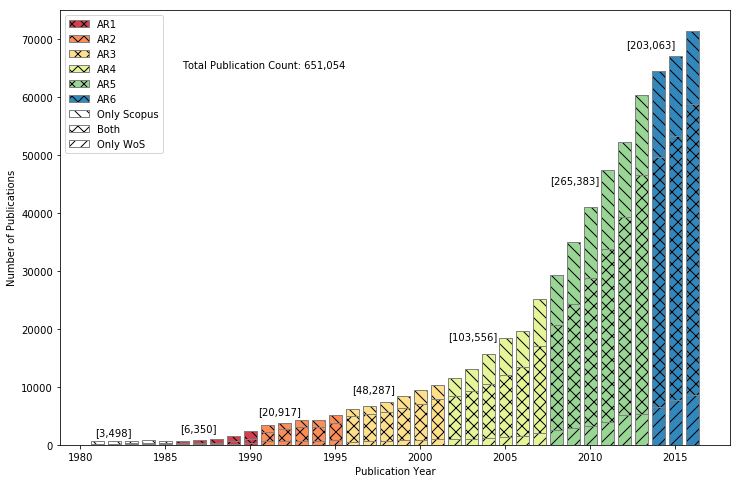

In [36]:
plt.rcParams["figure.figsize"] = [12,8]

bypy=bypy[bypy['PY']<2017]

edge="grey"
color = "white"

colors = {'NA':"white",'AR1':"#D53E4F", 'AR2':'#FC8D59', 'AR3':'#FEE08B', 'AR4':'#E6F598','AR5':'#99D594','AR6':'#3288BD'}

p1 = plt.bar(bypy.PY,bypy['only_wos'],color=bypy['AP'].apply(lambda x: colors[x]),edgecolor=edge, hatch=2*"/")
p2 = plt.bar(bypy.PY,bypy['both'],color=bypy['AP'].apply(lambda x: colors[x]),edgecolor=edge, hatch=2*"x",bottom=bypy['only_wos'])
p3 = plt.bar(bypy.PY,bypy['scopus'],color=bypy['AP'].apply(lambda x: colors[x]),edgecolor=edge, hatch=2*"\\",bottom=bypy['only_wos']+bypy['both'])

plt.legend(
    (p2[6],p2[10],p2[15],p2[22],p2[28],p2[35],p3[0],p2[0],p1[0]),
    ('AR1','AR2','AR3','AR4','AR5','AR6','Only Scopus','Both','Only WoS')
)

grouped = bypy[['AP','total','PY']].groupby('AP').agg([np.sum,np.mean])
print(grouped)
for index, row in grouped.iterrows():
    plt.text(
        row['PY']['mean'],
        row['total']['mean']+1000,
        "[{:,.0f}]".format(row['total']['sum']),
        ha='right'
    )

plt.text(1986,65000,"Total Publication Count: {:,}".format(bypy.total.sum()))
    #print(group.agg({}))
    
plt.xlabel('Publication Year')
plt.ylabel('Number of Publications')


plt.savefig('../plots/wos_scopus_docs_time.png',bbox_inches='tight')
plt.show()

In [8]:
bypy['total'] = bypy.only_wos + bypy.scopus + bypy.both
byap = bypy.groupby(['AP']).sum()
print(byap)

        PY  only_wos  scopus    both   total
AP                                          
NA    9915       528    1353     458    2339
AR1   9940      1013    2680    1368    5061
AR2   9965      3571    5938   11408   20917
AR3  11991      5325   10559   31002   46886
AR4  12027     17821   22956   43779   84556
AR5  12063     42025   54062  132698  228785
AR6   6045     39445   31084  105865  176394


In [9]:
bypy.total.sum()

564938